# Figure 3 and 4

The data needed to reproduce this figure is computed from the raw data by running the Notebook "aggregate_data.ipynb", which saves cumulative and randomised data to "Data/Cumulative" and "Data/Randomised" folders.


Plot for Heaps' Law and Taylor's Law. We use the type and token count for the temporally ordered cumulative and randomised cumulative data in the "output" folder. 

In [1]:
import os, sys, codecs
import numpy as np
import pylab as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.cm as cm
import gzip
import pandas as pd

In [2]:
sys.path.append(os.path.abspath(os.path.join(os.pardir,'src')))

from modules_distributor import fit
from general import *

In [3]:
# Function extracts the pre-computed hashtag type token counts from the "output" folder. The
# argument path points to the file path for the "output" folder. start_list and given_intervals
# are arguments provided in the "aggregate_data.ipynb" notebook. The output is two arrays, one for
# types and one for tokens. Each row in the array corresponds to different starting positions and
# each column corresponds to a different bin size.

def get_token_type_array(path, start_list, given_intervals):
    types_array = np.empty([len(start_list), len(given_intervals)-1]) 
    tokens_array = np.empty([len(start_list), len(given_intervals)-1]) 

    for i in range(len(start_list)):
        start = start_list[i]

        f_in = "types_tokens_count_start_" + str(start) + ".txt"
        f = open(path + f_in, "r")
        contents = f.read()
        f.close()

        res_list_temp = contents.split("\n")

        for j in range(len(res_list_temp)-1): # last element is empty, we cannot split it by ","
            split_result = res_list_temp[j].split(",")
            types_array[i, j]  = int(split_result[0])
            tokens_array[i, j] = int(split_result[1])
            
    return((tokens_array, types_array))

In [4]:
# Function that computes the standard deviation of hashtag type and token counts for different
# bin sizes. The input is the tokens and types array produced by get_token_type_array(). The
# output is 4 vectors corresponding to the mean and the standard deviation for the number of 
# types and tokens in each bin size.

def get_tokens_types_avg_std(tokens_array, types_array):
    tokens_avg = []
    tokens_std = []
    types_avg = []
    types_std = []
    
    for i in range(tokens_array.shape[1]): # iterating over the columns of the input arrays
        tokens_avg.append(np.mean(tokens_array[:,i]))
        tokens_std.append(np.std(tokens_array[:,i], ddof=1))
        types_avg.append(np.mean(types_array[:,i]))
        types_std.append(np.std(types_array[:,i], ddof=1))
        
    return((tokens_avg, tokens_std, types_avg, types_std)) # return a tuple

We will take random samples of 1, 2, 4 minutes, etc and calculate the number of tokens and types in each of these time intervals. We average this value and find the standard deviation (for both the tokens and types).

Minutes

In [5]:
twitter_min_path = "../hashtags_frequency_minutes/"
files_min = get_zipped_files(twitter_min_path, ".gz")
num_of_files = len(files_min)

In [6]:
path_in = '../output/Cumulative/min/'

start_list = list(range(3000, num_of_files, 3000))
given_intervals = np.concatenate(([0], np.power(2, range(10))))

token_type_tuple_min = get_token_type_array(path_in, start_list, given_intervals)

tokens_array_min = token_type_tuple_min[0]
types_array_min = token_type_tuple_min[1]

avg_std_min_tuple = get_tokens_types_avg_std(tokens_array_min, types_array_min)

In [7]:
tokens_min_avg = avg_std_min_tuple[0]
tokens_min_std = avg_std_min_tuple[1]
types_min_avg = avg_std_min_tuple[2]
types_min_std = avg_std_min_tuple[3]

Hour

In [11]:
twitter_hour_path = "../hashtags_frequency_day/"
files_hour = get_zipped_files(twitter_hour_path, ".gz")
num_of_files = len(files_hour)

In [12]:
path_in = '../output/Cumulative/hour/'

start_list = list(range(1000, num_of_files, 1000))
given_intervals = np.concatenate(([0], np.power(2, range(0, 8))))

token_type_tuple_hour = get_token_type_array(path_in, start_list, given_intervals)

tokens_array_hour= token_type_tuple_hour[0]
types_array_hour = token_type_tuple_hour[1]

avg_std_hour_tuple = get_tokens_types_avg_std(tokens_array_hour, types_array_hour)

tokens_hour_avg = avg_std_hour_tuple[0]
tokens_hour_std = avg_std_hour_tuple[1]
types_hour_avg = avg_std_hour_tuple[2]
types_hour_std = avg_std_hour_tuple[3]

Day

In [17]:
twitter_day_path = "../hashtags_frequency_day/"
files_day = get_zipped_files(twitter_day_path, ".gz")
num_of_files = len(files_day)

In [18]:
path_in = '../output/Cumulative/day/'

start_list = list(range(0, num_of_files - 16, 40))
given_intervals = np.concatenate(([0], np.power(2, [0, 1, 2, 3, 4])))

token_type_tuple_day = get_token_type_array(path_in, start_list, given_intervals)

tokens_array_day = token_type_tuple_day[0]
types_array_day = token_type_tuple_day[1]

types_day_avg = []
tokens_day_avg = []

types_day_std = []
tokens_day_std = []

for i in range(types_array_day.shape[1]): # iterating over columns
    types_day_avg.append(np.mean(types_array_day[:,i]))
    tokens_day_avg.append(np.mean(tokens_array_day[:,i]))
    types_day_std.append(np.std(types_array_day[:,i], ddof=1))
    tokens_day_std.append(np.std(tokens_array_day[:,i], ddof=1))

In [19]:
combined_tokens_avg = tokens_min_avg + tokens_day_avg
combined_types_avg = types_min_avg + types_day_avg

combined_tokens_std = tokens_min_std + tokens_day_std
combined_types_std = types_min_std + types_day_std 

coef = np.polyfit(np.log10(combined_tokens_avg), np.log10(combined_types_avg), 1) #0th element = slope, 1st element = intercept
plot_y = 10 ** coef[1] * combined_tokens_avg ** coef[0]

Taylor's Law

Fitting a linear regression to find exponent in Taylor's Law

In [27]:
coef_Taylor = np.polyfit(np.log10(combined_tokens_avg), np.log10(combined_tokens_std), 1) #ind 0  = slope, ind 1 = intercept
plot_y_Taylor = 10 ** coef_Taylor[1] * combined_tokens_avg ** coef_Taylor[0]
print("slope: ", coef_Taylor[0], ", intercept: ", coef_Taylor[1])

slope:  0.8352153750682361 , intercept:  0.354535610321173


# After randomisation/shuffling

In [28]:
def get_token_type_array_rand(path, N, given_intervals):
    types_array = np.empty([N, len(given_intervals)-1]) 
    tokens_array = np.empty([N, len(given_intervals)-1]) 
    
    for i in range(N):
        f_in = "types_tokens_count_start_" + str(i) + ".txt"
        f = open(path + f_in, "r")
        contents = f.read()
        f.close()

        res_list_temp = contents.split("\n")

        for j in range(len(res_list_temp)-1): # last element is empty, we cannot split it by ","
            split_result = res_list_temp[j].split(",")
            types_array[i, j]  = int(split_result[0])
            tokens_array[i, j] = int(split_result[1])
            
    return((tokens_array, types_array))

In [30]:
path_min = '../output/Random_Cumulative/min/'
path_hour = '../output/Random_Cumulative/hour/'
path_day = '../output/Random_Cumulative/day/'

N = 10

given_intervals_min = np.concatenate(([0], np.power(2, range(0, 12)))) 
given_intervals_hour = np.concatenate(([0], np.power(2, range(0, 11))))
given_intervals_day = np.concatenate(([0], np.power(2, range(0, 9))))                                    

Minute

In [31]:
token_type_tuple_min_rand = get_token_type_array_rand(path_min, N, given_intervals_min)

tokens_array_min_rand = token_type_tuple_min_rand[0]
types_array_min_rand = token_type_tuple_min_rand[1]

avg_std_min_rand_tuple = get_tokens_types_avg_std(tokens_array_min_rand, types_array_min_rand)

tokens_min_avg_rand = avg_std_min_rand_tuple[0]
tokens_min_std_rand = avg_std_min_rand_tuple[1]
types_min_avg_rand = avg_std_min_rand_tuple[2]
types_min_std_rand = avg_std_min_rand_tuple[3]

Hour

In [35]:
token_type_tuple_hour_rand = get_token_type_array_rand(path_hour, N, given_intervals_hour)

tokens_array_hour_rand = token_type_tuple_hour_rand[0]
types_array_hour_rand = token_type_tuple_hour_rand[1]

avg_std_hour_rand_tuple = get_tokens_types_avg_std(tokens_array_hour_rand, types_array_hour_rand)

tokens_hour_avg_rand = avg_std_hour_rand_tuple[0]
tokens_hour_std_rand = avg_std_hour_rand_tuple[1]
types_hour_avg_rand = avg_std_hour_rand_tuple[2]
types_hour_std_rand = avg_std_hour_rand_tuple[3]

Day

In [39]:
token_type_tuple_day_rand = get_token_type_array_rand(path_day, N, given_intervals_day)

tokens_array_day_rand = token_type_tuple_day_rand[0]
types_array_day_rand = token_type_tuple_day_rand[1]

avg_std_day_rand_tuple = get_tokens_types_avg_std(tokens_array_day_rand, types_array_day_rand)

tokens_day_avg_rand = avg_std_day_rand_tuple[0]
tokens_day_std_rand = avg_std_day_rand_tuple[1]
types_day_avg_rand = avg_std_day_rand_tuple[2]
types_day_std_rand = avg_std_day_rand_tuple[3]

# Heap's Law (Randomised)

In [44]:
combined_tokens_avg_rand = tokens_min_avg_rand + tokens_hour_avg_rand[6:]
combined_types_avg_rand = types_min_avg_rand + types_hour_avg_rand[6:]

combined_tokens_std_rand = tokens_min_std_rand + tokens_hour_std_rand[6:]
combined_types_std_rand = types_min_std_rand + types_hour_std_rand[6:]

coef_rand = np.polyfit(np.log10(combined_tokens_avg_rand), np.log10(combined_types_avg_rand), 1)
plot_y_rand = 10 ** coef_rand[1] * combined_tokens_avg_rand ** coef_rand[0]

slope:  0.7407046004440984 , intercept:  0.8111923475634897


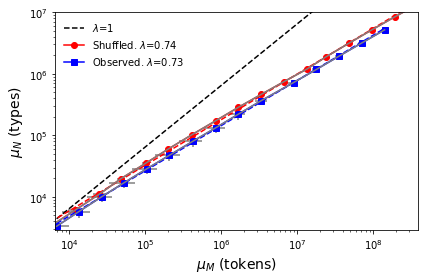

In [47]:
plt.plot(combined_tokens_avg, plot_Heaps_upper, "--", color = "black", label = r"$\lambda$=1") # Slope = 1

plt.errorbar(combined_tokens_avg_rand, combined_types_avg_rand, xerr = combined_tokens_std_rand, yerr = combined_types_std_rand, 
             color = "gray")
plt.errorbar(combined_tokens_avg, combined_types_avg, xerr = combined_tokens_std, yerr = combined_types_std, color = "gray")

plt.plot(combined_tokens_avg_rand, combined_types_avg_rand, "r-o", label = r"Shuffled. $\lambda$="+str(round(coef_rand[0], 2)))
plt.plot(combined_tokens_avg, combined_types_avg, 'b-s', label = r"Observed. $\lambda$=" + str(round(coef[0], 2)))

plt.plot(combined_tokens_avg, plot_y, '--', color = "blue")           # Line of Best Fit
plt.plot(combined_tokens_avg_rand, plot_y_rand, "--", color = "red")  # Line of Best Fit

plt.xlabel(r"$\mu_M$ (tokens)", fontsize = 14)
plt.ylabel(r"$\mu_N$ (types)", fontsize = 14)
plt.legend(frameon = False)
plt.loglog()
plt.xlim(6500, 385000000)
plt.ylim(2900, 10**7)
plt.tight_layout()
plt.show()

# Taylor's Law (Randomised)

In [50]:
shift_tokens = 10 ** (np.log(tokens_min_std_rand[-1])/np.log(tokens_day_std_rand[0]))

combined_avg_tokens_rand = tokens_min_avg_rand + tokens_day_avg_rand[2:-1]
combined_std_tokens_rand = tokens_min_std_rand + list(np.array(tokens_day_std_rand[2:-1])/shift_tokens)

coef_Taylor_rand = np.polyfit(np.log10(combined_avg_tokens_rand), np.log10(combined_std_tokens_rand), 1)
plot_y_Taylor_rand = 10 ** coef_Taylor_rand[1] * combined_avg_tokens_rand ** coef_Taylor_rand[0]

slope:  0.6030643408556747 , intercept:  0.9677504604784899


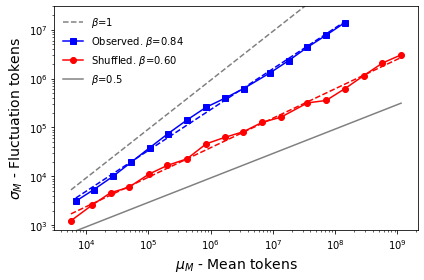

In [52]:
plot_y_lower = 10 ** coef_Taylor_rand[1] * np.array(combined_avg_tokens_rand) ** 0.5 # Two extreme slopes
plot_y_upper = 0.1 * (10 ** coef_Taylor_rand[1] * np.array(combined_avg_tokens_rand) ** 1)

plt.plot(combined_avg_tokens_rand, plot_y_upper, "--", color = "grey",label=r"$\beta$=1")
plt.plot(combined_tokens_avg, combined_tokens_std, 's-b', label = r"Observed. $\beta$=" + str(round(coef_Taylor[0], 2)))
plt.plot(combined_avg_tokens_rand, combined_std_tokens_rand, "o-r", label = r"Shuffled. $\beta$="+ str('{:.2f}'.format(round(coef_Taylor_rand[0], 2))))
plt.plot(combined_avg_tokens_rand, plot_y_Taylor_rand, "--r")
plt.plot(combined_tokens_avg, plot_y_Taylor, '--b')
plt.plot(combined_avg_tokens_rand, plot_y_lower, "-", color = "grey", label = r"$\beta$=0.5")
plt.loglog()
plt.xlabel(r"$\mu_M$ - Mean tokens", fontsize = 14)
plt.ylabel(r"$\sigma_M$ - Fluctuation tokens", fontsize = 14)
plt.legend(frameon = False)
plt.tight_layout()
plt.show()